In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
tf.compat.v1.enable_eager_execution()

In [3]:
(train_set, valid_set, test_set), info = tfds.load('mnist',split = ['train[0%:75%]','train[75%:90%]','train[90%:100%]'],as_supervised = True,with_info = True)

In [4]:
images_np_train = np.zeros(shape = [45000,28,28,1])
label_np_train = np.zeros(shape = [45000])
images_np_valid = np.zeros(shape = [9000,28,28,1])
label_np_valid = np.zeros(shape = [9000])
images_np_test = np.zeros(shape = [6000,28,28,1])
label_np_test = np.zeros(shape = [6000])
i = 0
j = 0
k = 0
for image,label in train_set:
    images_np_train[i,:,:,:] = image.numpy()
    label_np_train[i] = label
    i += 1
for image,label in valid_set:
    images_np_valid[j,:,:,:] = image.numpy()
    label_np_valid[j] = label
    j += 1
for image,label in test_set:
    images_np_test[k,:,:,:] = image.numpy()
    label_np_test[k] = label
    k += 1

train_set = tf.data.Dataset.from_tensor_slices((images_np_train,label_np_train))
valid_set = tf.data.Dataset.from_tensor_slices((images_np_valid,label_np_valid))
test_set = tf.data.Dataset.from_tensor_slices((images_np_test,label_np_test))

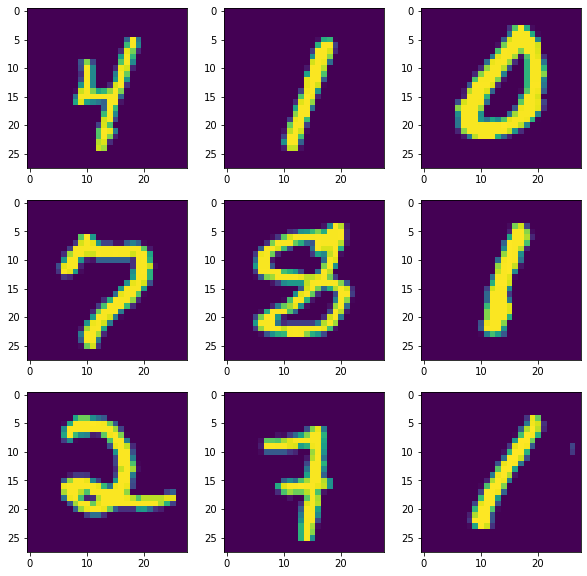

In [5]:
fig,ax = plt.subplots(3,3,figsize = (10,10))
i = 0
index = 0
for image,label in train_set.take(9):
    ax[index,i].imshow(image)
    if i == 2:
        index += 1
        i = 0
        continue
    i += 1

In [6]:
train_set = train_set.shuffle(1000)
valid_set = valid_set.shuffle(1000)
test_set = test_set.shuffle(1000)

In [7]:
train_set = train_set.batch(32)
valid_set = valid_set.batch(32)
test_set = test_set.batch(32)

In [8]:
train_image_tensor = tf.TensorArray(tf.uint8,size = train_set.cardinality(), clear_after_read=False)
train_label_tensor = tf.TensorArray(tf.int64,size = train_set.cardinality(), clear_after_read=False)

In [ ]:
""" images_np = np.zeros(shape = [45000,28,28,1])
label_np = np.zeros(shape = [45000])
i = 0
for image,label in train_set:
    train_image_tensor = train_image_tensor.write(i,image)
    train_label_tensor = train_label_tensor.write(i,label)
    i += 1 
for image,label in train_set:
    images_np[i,:,:,:] = image.numpy()
    label_np[i] = label
    i += 1 """

In [9]:
random_angles = tf.random.uniform(shape = (train_image_tensor.size().numpy(),),minval = 0, maxval = np.pi/2)
#convert the above to a numpy array to be made into a dataset for preprocessing
random_angles_np = random_angles.numpy()

In [ ]:
""" train_dataset_with_angles = tf.data.Dataset.from_tensor_slices((images_np,random_angles_np)) """

In [10]:
class augmentationlayer(keras.layers.Layer):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
        self.aug_model = tf.keras.Sequential()
    def call(self,image,angle):
        angle = angle.numpy()
        self.aug_model.add(tf.keras.layers.experimental.preprocessing.RandomRotation(abs(angle)))
        image = tf.expand_dims(image,0)
        rotated_img = self.aug_model(image)
        return rotated_img[0,:,:,:],angle

In [11]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model_1 = tf.keras.models.Sequential()
model_1.add(tf.keras.layers.Conv2D(32,kernel_size = 3,padding = "SAME", activation = "relu"))
model_1.add(tf.keras.layers.Conv2D(64,kernel_size = 3,padding = "SAME",
activation = "relu"))
model_1.add(tf.keras.layers.MaxPool2D())
model_1.add(tf.keras.layers.Flatten())
model_1.add(tf.keras.layers.Dropout(0.25))
model_1.add(tf.keras.layers.Dense(128, activation = "relu"))
model_1.add(tf.keras.layers.Dropout(0.5))
model_1.add(tf.keras.layers.Dense(10, activation = "softmax"))

In [12]:
model_1.compile(loss = "sparse_categorical_crossentropy", optimizer = "nadam",
metrics = "accuracy")

model_1.fit(train_set, epochs = 10, validation_data=valid_set)

Epoch 1/10
1407/1407 [==============================] - 192s 135ms/step - loss: 1.7862 - accuracy: 0.7667 - val_loss: 0.0932 - val_accuracy: 0.9741
Epoch 2/10
1407/1407 [==============================] - 183s 130ms/step - loss: 0.1711 - accuracy: 0.9519 - val_loss: 0.0914 - val_accuracy: 0.9762
Epoch 3/10
1407/1407 [==============================] - 180s 128ms/step - loss: 0.1291 - accuracy: 0.9639 - val_loss: 0.0750 - val_accuracy: 0.9810
Epoch 4/10
1407/1407 [==============================] - 182s 129ms/step - loss: 0.1042 - accuracy: 0.9707 - val_loss: 0.0570 - val_accuracy: 0.9851
Epoch 5/10
1407/1407 [==============================] - 182s 129ms/step - loss: 0.0838 - accuracy: 0.9760 - val_loss: 0.0700 - val_accuracy: 0.9833
Epoch 6/10
1407/1407 [==============================] - 184s 131ms/step - loss: 0.0802 - accuracy: 0.9773 - val_loss: 0.0753 - val_accuracy: 0.9844
Epoch 7/10
1407/1407 [==============================] - 181s 129ms/step - loss: 0.0695 - accuracy: 0.9795 - val_

In [13]:
model_1.evaluate(images_np_test,label_np_test)

188/188 [==============================] - 4s 17ms/step - loss: 0.0735 - accuracy: 0.9852


[0.07353276759386063, 0.9851666688919067]

In [25]:
#random cropping function 
augmentationlayer = tf.keras.models.Sequential()
#random flip
augmentationlayer.add(tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"))

In [26]:
augmented_ds = train_set.map(lambda image,label:(augmentationlayer(image,training = True),label))

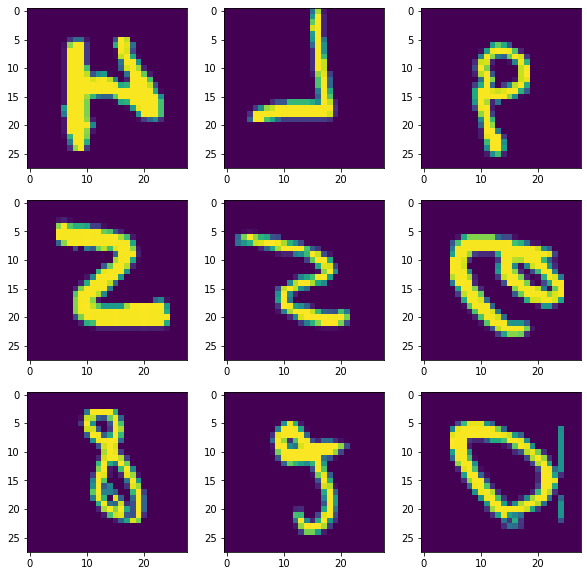

In [27]:
fig,ax_aug = plt.subplots(3,3,figsize = (10,10))
index = 0
i = 0
for image, label in augmented_ds.take(9):
    ax_aug[index,i].imshow(image[0,:,:,:])
    if i == 2:
        index += 1
        i = 0
        continue
    i += 1

Images have been augmented to be cropped randomly and also randomly flipped. 

In [28]:
model_2 = tf.keras.models.Sequential()
model_2.add(tf.keras.layers.Conv2D(32,kernel_size = 3,padding = "SAME", activation = "relu"))
model_2.add(tf.keras.layers.Conv2D(64,kernel_size = 3,padding = "SAME",
activation = "relu"))
#model_2.add(tf.keras.layers.Conv2D(128,kernel_size = 3, padding = "SAME", activation = "elu"))
model_2.add(tf.keras.layers.MaxPool2D())
model_2.add(tf.keras.layers.Flatten())
model_2.add(tf.keras.layers.Dropout(0.25))
model_2.add(tf.keras.layers.Dense(128, activation = "relu"))
model_2.add(tf.keras.layers.Dropout(0.5))
model_2.add(tf.keras.layers.Dense(10, activation = "softmax"))

In [29]:
model_2.compile(loss = "sparse_categorical_crossentropy", optimizer = "nadam",
metrics = "accuracy")

model_2.fit(augmented_ds, epochs = 15, validation_data=valid_set)

Epoch 1/15
1407/1407 [==============================] - 138s 97ms/step - loss: 2.4943 - accuracy: 0.4407 - val_loss: 0.7564 - val_accuracy: 0.7847
Epoch 2/15
1407/1407 [==============================] - 139s 99ms/step - loss: 0.5953 - accuracy: 0.8045 - val_loss: 0.2541 - val_accuracy: 0.9226
Epoch 3/15
1407/1407 [==============================] - 149s 106ms/step - loss: 0.4067 - accuracy: 0.8707 - val_loss: 0.1777 - val_accuracy: 0.9476
Epoch 4/15
1407/1407 [==============================] - 149s 106ms/step - loss: 0.3459 - accuracy: 0.8927 - val_loss: 0.1881 - val_accuracy: 0.9444
Epoch 5/15
1407/1407 [==============================] - 144s 102ms/step - loss: 0.3097 - accuracy: 0.9059 - val_loss: 0.1782 - val_accuracy: 0.9449
Epoch 6/15
1407/1407 [==============================] - 150s 106ms/step - loss: 0.2807 - accuracy: 0.9136 - val_loss: 0.1680 - val_accuracy: 0.9519
Epoch 7/15
1407/1407 [==============================] - 149s 106ms/step - loss: 0.2564 - accuracy: 0.9200 - val_lo

As the addition of an augmentation layer resuls in moe complex features for the network to handle, we shall increase the model with one more convolutional layer.

In [30]:
model_3 = tf.keras.models.Sequential()
model_3.add(tf.keras.layers.Conv2D(32,kernel_size = 3,padding = "SAME", activation = "relu"))
model_3.add(tf.keras.layers.Conv2D(64,kernel_size = 3,padding = "SAME",
activation = "relu"))
model_3.add(tf.keras.layers.Conv2D(128,kernel_size = 3, padding = "SAME", activation = "elu"))
model_3.add(tf.keras.layers.MaxPool2D())
model_3.add(tf.keras.layers.Flatten())
model_3.add(tf.keras.layers.Dropout(0.25))
model_3.add(tf.keras.layers.Dense(128, activation = "relu"))
model_3.add(tf.keras.layers.Dropout(0.5))
model_3.add(tf.keras.layers.Dense(10, activation = "softmax"))

In [31]:
model_3.compile(loss = "sparse_categorical_crossentropy", optimizer = "nadam",
metrics = "accuracy")

model_3.fit(augmented_ds, epochs = 15, validation_data=valid_set)

Epoch 1/15
1407/1407 [==============================] - 333s 236ms/step - loss: 1.5505 - accuracy: 0.5957 - val_loss: 0.4073 - val_accuracy: 0.8726
Epoch 2/15
1407/1407 [==============================] - 345s 245ms/step - loss: 0.4355 - accuracy: 0.8627 - val_loss: 0.2613 - val_accuracy: 0.9239
Epoch 3/15
1407/1407 [==============================] - 345s 245ms/step - loss: 0.3494 - accuracy: 0.8916 - val_loss: 0.2007 - val_accuracy: 0.9388
Epoch 4/15
1407/1407 [==============================] - 346s 246ms/step - loss: 0.3126 - accuracy: 0.9061 - val_loss: 0.2104 - val_accuracy: 0.9366
Epoch 5/15
1407/1407 [==============================] - 342s 243ms/step - loss: 0.2849 - accuracy: 0.9118 - val_loss: 0.1637 - val_accuracy: 0.9541
Epoch 6/15
1407/1407 [==============================] - 321s 228ms/step - loss: 0.2697 - accuracy: 0.9176 - val_loss: 0.1722 - val_accuracy: 0.9521
Epoch 7/15
1407/1407 [==============================] - 411s 292ms/step - loss: 0.2604 - accuracy: 0.9202 - val_

In [34]:
import os
image_path = os.path.join(r'C:\Users\ASUS\Desktop\Web Dev Tutorial',r'nba.jpg')

In [35]:
image_path

'C:\\Users\\ASUS\\Desktop\\Web Dev Tutorial\\nba.jpg'

In [36]:
img = tf.io.read_file(image_path)

In [38]:
img = tf.io.decode_image(img, channels = 3,dtype = tf.float32)
img

<tf.Tensor: shape=(233, 118, 3), dtype=float32, numpy=
array([[[0.9686275, 0.9686275, 0.9686275],
        [0.9686275, 0.9686275, 0.9686275],
        [0.9686275, 0.9686275, 0.9686275],
        ...,
        [0.9686275, 0.9686275, 0.9686275],
        [0.9686275, 0.9686275, 0.9686275],
        [0.9686275, 0.9686275, 0.9686275]],

       [[0.9686275, 0.9686275, 0.9686275],
        [0.9686275, 0.9686275, 0.9686275],
        [0.9686275, 0.9686275, 0.9686275],
        ...,
        [0.9686275, 0.9686275, 0.9686275],
        [0.9686275, 0.9686275, 0.9686275],
        [0.9686275, 0.9686275, 0.9686275]],

       [[0.9686275, 0.9686275, 0.9686275],
        [0.9686275, 0.9686275, 0.9686275],
        [0.9686275, 0.9686275, 0.9686275],
        ...,
        [0.9686275, 0.9686275, 0.9686275],
        [0.9686275, 0.9686275, 0.9686275],
        [0.9686275, 0.9686275, 0.9686275]],

       ...,

       [[0.9686275, 0.9686275, 0.9686275],
        [0.9686275, 0.9686275, 0.9686275],
        [0.9686275, 0.96862

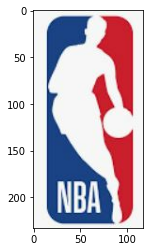

In [39]:
plt.imshow(img)